# 训练一个分类器  

你已经学会如何去定义一个神经网络,计算损失值和更新网络的权重。

你现在可能在思考：数据哪里来呢？

In [2]:
%matplotlib inline

通常，当你处理图像，文本，音频和视频数据时，你可以使用标准的Python包来加载数据到一个numpy数组中.然后把这个数组转换成torch.*Tensor。

- 对于图像,有诸如Pillow,OpenCV包等非常实用
- 对于音频,有诸如scipy和librosa包
- 对于文本,可以用原始Python和Cython来加载,或者使用NLTK和SpaCy 

对于视觉,我们创建了一个torchvision包,包含常见数据集的数据加载,比如Imagenet,CIFAR10,MNIST等,和图像转换器,也就是torchvision.datasets和torch.utils.data.DataLoader。
 
这提供了巨大的便利,也避免了代码的重复。

在这个教程中,我们使用CIFAR10数据集,它有如下10个类别:`airplane`,`automobile`,`bird`,`cat`,`deer`,`dog`,`frog`,`horse`,`ship`,`truck`。

这个数据集中的图像大小为3 * 32 * 32,即,3通道,32*32像素。  
![cifar10](../assets/cifar10.png)

## 训练一个图像分类器

我们将按照下列顺序进行:

- 使用torchvision加载和归一化CIFAR10训练集和测试集.
- 定义一个卷积神经网络
- 定义损失函数
- 在训练集上训练网络
- 在测试集上测试网络

### 1. 加载和归一化CIFAR10  

使用torchvision加载CIFAR10是非常容易的。

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


torchvision的输出是[0,1]的PILImage图像,我们把它转换为归一化范围为[-1, 1]的张量。

注意
> 如果在Windows上运行时出现BrokenPipeError，尝试将torch.utils.data.DataLoader()的num_worker设置为0。

In [20]:
transform = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../dataset/', train=True,
                                       download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)
trainloader = DataLoader(trainset, batch_size=batch_size,
                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../dataset/', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


我们展示一些有趣的训练图像。

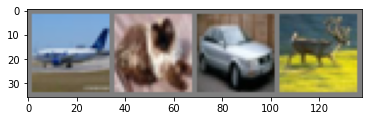

plane  cat  car deer


In [52]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(''.join('%5s' % classes[labels[j]] for j in range(batch_size)))


### 2. 定义一个卷积神经网络  

从之前的神经网络一节复制神经网络代码,并修改为接受3通道图像取代之前的接受单通道图像。

In [70]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 1 -- 输入图像通道数， 6 -- 输出通道数， 5x5 -- square convolution（平方卷积）
        # kernel
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.conv2 = nn.Conv2d(3, 16, 5)
        # 仿射运算  -- an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5*5 from image dimension(图像维度)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        #如果大小为正方形，则可以使用单个数字指定
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
                                # 展开除批次维度以外的所有维度
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
# print(net)

# ----第二种方式----
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

### 3. 定义损失函数和优化器  

我们使用交叉熵作为损失函数,使用带动量的随机梯度下降。

In [71]:
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 训练网络  

这是开始有趣的时刻，我们只需在数据迭代器上循环,把数据输入给网络,并优化。

In [72]:
for epoch in range(2):  # loop over the dataset multiple times - 在数据集上循环多次

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.196
[1,  4000] loss: 1.840
[1,  6000] loss: 1.697
[1,  8000] loss: 1.645
[1, 10000] loss: 1.547
[1, 12000] loss: 1.512


KeyboardInterrupt: 

保存一下我们的训练模型

In [56]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

点击[这里](https://pytorch.org/docs/stable/notes/serialization.html)查看关于保存模型的详细介绍

### 5. 在测试集上测试网络  

我们在整个训练集上训练了两次网络,但是我们还需要检查网络是否从数据集中学习到东西。

我们通过预测神经网络输出的类别标签并根据实际情况进行检测，如果预测正确,我们把该样本添加到正确预测列表。

第一步，显示测试集中的图片一遍熟悉图片内容。

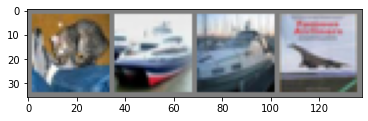

GroundTruth:    cat  ship  ship plane


In [57]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

接下来，让我们重新加载我们保存的模型(注意:保存和重新加载模型在这里不是必要的，我们只是为了说明如何这样做)：

In [58]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

现在我们来看看神经网络认为以上图片是什么?

In [59]:
outputs = net(images)

输出是10个标签的概率。一个类别的概率越大,神经网络越认为他是这个类别。所以让我们得到最高概率的标签。

In [60]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


接下来让我们看看网络在整个测试集上的结果如何。


In [61]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


结果看起来好于偶然，偶然的正确率为10%,似乎网络学习到了一些东西。

那在什么类上预测较好，什么类预测结果不好呢？

In [62]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 56.4 %
Accuracy for class car   is: 61.6 %
Accuracy for class bird  is: 31.7 %
Accuracy for class cat   is: 34.9 %
Accuracy for class deer  is: 50.6 %
Accuracy for class dog   is: 55.8 %
Accuracy for class frog  is: 61.7 %
Accuracy for class horse is: 61.3 %
Accuracy for class ship  is: 70.9 %
Accuracy for class truck is: 76.3 %


接下来干什么?

我们如何在GPU上运行神经网络呢?

## 在GPU上训练  

你是如何把一个Tensor转换GPU上,你就如何把一个神经网络移动到GPU上训练。这个操作会递归遍历有所模块,并将其参数和缓冲区转换为CUDA张量。

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


接下来假设我们有一台CUDA的机器

然后这些方法将递归遍历所有模块并将其参数和缓冲区转换为CUDA张量：

In [64]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

请记住，你也必须在每一步中把你的输入和目标值转换到GPU上:

In [65]:
inputs, labels = data[0].to(device), data[0].to(device)

为什么我们没注意到GPU的速度提升很多?那是因为网络非常的小。

**实践:**

尝试增加你的网络的宽度(第一个nn.Conv2d的第2个参数, 第二个nn.Conv2d的第一个参数,他们需要是相同的数字),看看你得到了什么样的加速。

**实现的目标:**
- 深入了解了PyTorch的张量库和神经网络
- 训练了一个小网络来分类图片

###  在多GPU上训练  

如果你希望使用所有GPU来更大的加快速度,请查看[选读:数据并行](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

